<h1> Ensemble script for FATES-SP runs </h1>

This script will 

<ol>
<li>Clone github repo and move to CLM-FATES-SP pull request branchs
<li>Make a default 4x5 CLM-FATES-SP case
<li>Make an ensemble of CLM-FATES-SP cases 
<li>Generate an ensemble of parameter files with one at a time modification
<li>Point each ensemble member at a different parameter file
<li>Submit all these jobs
<li>Analyse output
</ol>

<h4>n.b. 1. Most of the decisions here on compsets, FATES options, resolution, variables etc. are easy to modify. </h4>
<h4>n.b. 2. This notebook is also set up to wok with Cheyenne specific paths. Making it machine agnostic is tbd.</h4>

<h3>Set global variables and paths for ensemble analysis </h3>

In [1]:
#set global variables to pass into BASH commands. 

ctsmrepo='ctsmsept20'
defbuildroot='/glade/scratch/'

#Settings for the SP ensemble
sp=0
noc4=1
hydro=0
if(sp == 1):
    resub=0
    ncases=14
    ychoose =2009
    defcase='SPdefault'
    defbuildroot='/glade/scratch/'
    if(noc4 == 1):
        ens_directory='SPfates_ens_noc4'
        caseroot='spfates_noc4_n'
        paramsdir='param_files_sp_noc4'
        paramfiledefault='fates_params_default_noc4.nc'
        if(hydro == 1):
            ens_directory='SPfates_ens_noc4_hydro'
            caseroot='spfates_noc4_hydro_n'
            paramsdir='param_files_sp_noc4_hydro'
            paramfiledefault='fates_params_default_noc4.nc'        
    else:
        ens_directory='SPfates_ens'
        caseroot='spfates_01_n'
        paramsdir='param_files_sp'
        paramfiledefault='fates_params_default.nc'
else:
#Settings for the NOCOMP ensemble. 
#set global variables to pass into BASH commands. 
    sp=0
    defcase='SPdefault'
    ens_directory='NOCOMP_fates_ens'
    caseroot='nocomp_fates_02_n'
    paramsdir='param_files_nocomp'
    paramfiledefault='fates_params_default.nc'    
    resub=2
    ncases=14
    ychoose =2009
print(paramsdir)
print(sp)

param_files_nocomp
0


<h3> Control variables for the analysis script.</h3>

In [2]:
dosubmit=0
forcenewcase=0
doanalysis=1

In [3]:
import os
notebookdr=os.getcwd() 

<h3>Clone CTSM repo, switch to SP pull request code.</h3>

In [4]:
%%bash -s "$ctsmrepo"
ctsmrepo=$1

cd /glade/work/$USER/
#go to git directory
if [[ -d "git" ]]
then
cd git/
else
mkdir git
cd git
fi

#go to git repo, or checkout code
if [[ -d "$ctsmrepo" ]]
then
cd $ctsmrepo
else

#clone CTSM code
git clone https://github.com/escomp/ctsm $ctsmrepo
cd $ctsmrepo
./manage_externals/checkout_externals
cd src

#change CTSM code to SP branch. 
git remote add  rosie_ctsm_repo  https://github.com/rosiealice/ctsm
git fetch rosie_ctsm_repo
git checkout -b SP_api rosie_ctsm_repo/SP_api

#change FATES code to SP branch. 
cd fates
git remote add  rosie_fates_repo https://github.com/rosiealice/fates
git fetch rosie_fates_repo
git checkout -b fates_sp_sept rosie_fates_repo/fates_sp_sept
fi

<h3> Make a default FATES 4x5 case </h3>

In [5]:
%%bash -s "$ctsmrepo" "$defcase"

ctsmrepo=$1
defcase=$2

cd /glade/work/$USER/git/$ctsmrepo/cime/scripts
pwd
if [[ -d "$defcase" ]]
then
    echo "$defcase exists on your filesystem."
else
cd $defcase
./create_newcase --case $defcase --compset 2000_DATM%GSWP3v1_CLM50%FATES_SICE_SOCN_MOSART_CISM2%NOEVOLVE_SWAV_SIAC_SESP --res f45_f45_mg37  --run-unsupported
./case.setup
./case.build
fi

cd $casename

/glade/work/rfisher/git/ctsmsept20/cime/scripts
SPdefault exists on your filesystem.


<h3> Adjust settings of default case. </h3>

In [6]:
%%bash -s "$ctsmrepo" "$defcase" "$defbuildroot" 

ctsmrepo=$1
defcase=$2
defbuildroot=$3

defbld=$defbuildroot$USER/$defcase/bld
echo $defbld
cd /glade/work/$USER/git/$ctsmrepo/cime/scripts/$defcase

echo 'updating settings',$newcase
./xmlchange BUILD_COMPLETE=TRUE;
./xmlchange EXEROOT=$defbld;
./xmlchange CONTINUE_RUN=FALSE;
./xmlchange --id STOP_N --val 10;
./xmlchange --id STOP_OPTION --val nyears;
./xmlchange --id CLM_FORCE_COLDSTART --val on;


/glade/scratch/rfisher/SPdefault/bld
updating settings,
For your changes to take effect, run:
./case.build --clean-all
./case.build
For your changes to take effect, run:
./case.build --clean-all
./case.build


<h3> Make Default user_nl_clm File </h3>

In [7]:
%%bash -s "$ctsmrepo" "$defcase" "$notebookdr" "$paramsdir" "$hydro" "$sp"

ctsmrepo=$1
echo $ctsmrepo
defcase=$2
notebookdr=$3
paramsdir=$4
hydro=$5
sp=$6

echo $sp

echo $notebookdr/$paramsdir/

cd $notebookdr
if [[ -d "$paramsdir" ]]
then
   echo "existing param firectory"
else 
    mkdir $paramsdir
    echo "made param firectory"
fi
pwd

echo $paramsdir
cd /glade/work/$USER/git/$ctsmrepo/cime/scripts
pwd
cp  $defcase/user_nl_clm $notebookdr/$paramsdir/user_nl_clm_default

cd $notebookdr
cd $paramsdir
pftfilename_def=$notebookdr/$paramsdir

if [ $sp -eq 1 ]
then
echo use_fates_sp=.true. >> user_nl_clm_default
fi

echo use_fates_nocomp=.true. >> user_nl_clm_default
echo use_fates_fixed_biogeog=.true. >> user_nl_clm_default
echo fates_paramfile=\'\pftfilename_default\' >> user_nl_clm_default

if [ $hydro -eq 1 ]
then
echo use_fates_planthydro=.true. >> user_nl_clm_default
fi

cat  $notebookdr/$paramsdir/user_nl_clm_default

ctsmsept20
0
/glade/u/home/rfisher/fates_sp_ensembles/param_files_nocomp/
existing param firectory
/glade/u/home/rfisher/fates_sp_ensembles
param_files_nocomp
/glade/work/rfisher/git/ctsmsept20/cime/scripts
!----------------------------------------------------------------------------------
! Users should add all user specific namelist changes below in the form of 
! namelist_var = new_namelist_value 
!
! EXCEPTIONS: 
! Set use_cndv           by the compset you use and the CLM_BLDNML_OPTS -dynamic_vegetation setting
! Set use_vichydro       by the compset you use and the CLM_BLDNML_OPTS -vichydro           setting
! Set use_cn             by the compset you use and CLM_BLDNML_OPTS -bgc  setting
! Set use_crop           by the compset you use and CLM_BLDNML_OPTS -crop setting
! Set spinup_state       by the CLM_BLDNML_OPTS -bgc_spinup      setting
! Set co2_ppmv           with CCSM_CO2_PPMV                      option
! Set dtime              with L_NCPL                             optio

<h3> Make ensemble of cases.</h3>

In [8]:
%%bash -s "$ctsmrepo" "$defcase" "$ens_directory" "$caseroot" $ncases "$forcenewcase"

ctsmrepo=$1
defcase=$2
ens_directory=$3
caseroot=$4
ncases=$5
forcenewcase=$6

echo $ncases
echo $caseroot
echo $ens_directory
echo $ctsmrepo

cd /glade/work/$USER/git/$ctsmrepo/cime/scripts
pwd

if [[ -d "$ens_directory" ]]
then
echo "directory already exists"
else
mkdir $ens_directory
fi 

counter1=0 #include a default zero case. 
while [ $counter1 -le $ncases ]
do
  newcase=$caseroot$counter1
  rm -rf $newcase 
  if [ -d $ens_directory/$newcase ]
  then
    echo ' new case already exists',$ens_directory/$newcase   
  else
   echo 'making', $newcase
    ./create_clone --clone $defcase --case $ens_directory/$newcase ;
    cd $ens_directory/$newcase 
    ./case.setup;
    cd ../../
  fi
  if [ $forcenewcase -eq 1 ]
  then
   echo 'force making', $ens_directory/$newcase
    rm -rf $ens_directory/$newcase
    ./create_clone --clone $defcase --case $ens_directory/$newcase ;
    cd $ens_directory/$newcase
    ./case.setup;
    cd ../../
  fi

  ((counter1++))
  done    


14
nocomp_fates_02_n
NOCOMP_fates_ens
ctsmsept20
/glade/work/rfisher/git/ctsmsept20/cime/scripts
directory already exists
 new case already exists,NOCOMP_fates_ens/nocomp_fates_02_n0
 new case already exists,NOCOMP_fates_ens/nocomp_fates_02_n1
 new case already exists,NOCOMP_fates_ens/nocomp_fates_02_n2
 new case already exists,NOCOMP_fates_ens/nocomp_fates_02_n3
 new case already exists,NOCOMP_fates_ens/nocomp_fates_02_n4
 new case already exists,NOCOMP_fates_ens/nocomp_fates_02_n5
 new case already exists,NOCOMP_fates_ens/nocomp_fates_02_n6
 new case already exists,NOCOMP_fates_ens/nocomp_fates_02_n7
 new case already exists,NOCOMP_fates_ens/nocomp_fates_02_n8
 new case already exists,NOCOMP_fates_ens/nocomp_fates_02_n9
 new case already exists,NOCOMP_fates_ens/nocomp_fates_02_n10
 new case already exists,NOCOMP_fates_ens/nocomp_fates_02_n11
 new case already exists,NOCOMP_fates_ens/nocomp_fates_02_n12
 new case already exists,NOCOMP_fates_ens/nocomp_fates_02_n13
 new case already ex

<h3> Create .nc version of current defualt file. I FAILED ATT THIS. NEEDS INPUT..</h3>
You currently have to do this step manually, by doing this in the terminal:

<i> cd /glade/work/$USER/git/$ctsmrepo/src/fates/parameter_files/</i><br>
<i>ncgen -o fates_params_default.nc fates_params_default.cdl </i>

<h3> Make a directory for the parameter files to go in and copy default .nc parameter file there. </h3>

In [9]:
%%bash -s "$ctsmrepo" "$notebookdr"  "$paramsdir" "$paramfiledefault"
echo $1
ctsmrepo=$1
notebookdr=$2
paramsdir=$3
paramfiledefault=$4
echo $ctsmrepo


cd $notebookdr
if [[ -d "$paramsdir" ]]
then
   cd $paramsdir
   echo "existing param firectory"
else 
    mkdir $paramsdir
    cd $paramsdir
    echo "made param firectory"
fi
pwd
echo $paramfiledefault
cp /glade/work/$USER/git/$ctsmrepo/src/fates/parameter_files/$paramfiledefault $paramfiledefault



ctsmsept20
ctsmsept20
existing param firectory
/glade/u/home/rfisher/fates_sp_ensembles/param_files_nocomp
fates_params_default.nc


<h3>Mpdify default parameter file</h3>

In [10]:
import netCDF4 as nc4
import sys
import os
import shutil

def copy_clobber(filename1, filename2):
    try:
        os.remove(filename2)
       # print('replacing file: '+filename2)
    except:
        print('file does not yet exist: '+filename2)
    shutil.copyfile(filename1, filename2)


filename_template = notebookdr+'/'+paramsdir+'/'+paramfiledefault

def def_pftfile(notebookdr, paramsdir,i,variable,delta):
    filename_out= notebookdr+'/'+paramsdir+'/fates_params_update_'+str(i)+'.nc'
    print(filename_out)
    print(filename_template)
    copy_clobber(filename_template,filename_out)

    fin = nc4.Dataset(filename_out, 'r+')
    print(filename_out)
    var = fin.variables[variable]
    var[:] = var[:]*delta
    fin.close()
    
#1 fates_leaf_clumping_index +-10% (not above 1)
#2 fates_leaf_diameter +- 20%
#3 fates_leaf_stomatal_slope_ballberry +- 20%
#4 fates_leaf_vcmax25top +- 20%
#5 Fates_leaf_xl = +- 20%
#6 fates_rholvis=+-20-%
#7 Fates_smpsc=+-20%
#default    
print(paramsdir)
def_pftfile(notebookdr, paramsdir,0,'fates_leaf_clumping_index',1.0)

    
def_pftfile(notebookdr, paramsdir,1,'fates_leaf_clumping_index',0.9)
def_pftfile(notebookdr, paramsdir,2,'fates_leaf_clumping_index',1.1)

def_pftfile(notebookdr, paramsdir,3,'fates_leaf_diameter',0.5)
def_pftfile(notebookdr, paramsdir,4,'fates_leaf_diameter',2.0)

def_pftfile(notebookdr, paramsdir,5,'fates_leaf_stomatal_slope_ballberry',0.8)
def_pftfile(notebookdr, paramsdir,6,'fates_leaf_stomatal_slope_ballberry',1.2)

def_pftfile(notebookdr, paramsdir,7,'fates_leaf_vcmax25top',0.8)
def_pftfile(notebookdr, paramsdir,8,'fates_leaf_vcmax25top',1.2)

def_pftfile(notebookdr, paramsdir,9,'fates_leaf_xl',0.8)
def_pftfile(notebookdr, paramsdir,10,'fates_leaf_xl',1.2)

def_pftfile(notebookdr, paramsdir,11,'fates_rholvis',0.8)
def_pftfile(notebookdr, paramsdir,12,'fates_rholvis',1.2)

def_pftfile(notebookdr, paramsdir,13,'fates_smpsc',0.5)
def_pftfile(notebookdr, paramsdir,14,'fates_smpsc',1.5)

if(sp==0):
    def_pftfile(notebookdr, paramsdir,1,'fates_prt_nitr_stoich_p1',0.8)
    def_pftfile(notebookdr, paramsdir,2,'fates_prt_nitr_stoich_p1',1.2)

    def_pftfile(notebookdr, paramsdir,3,'fates_allom_l2fr',0.8)
    def_pftfile(notebookdr, paramsdir,4,'fates_allom_l2fr',1.2)

    def_pftfile(notebookdr, paramsdir,5,'fates_allom_la_per_sa_int',0.8)
    def_pftfile(notebookdr, paramsdir,6,'fates_allom_la_per_sa_int',1.2)

    def_pftfile(notebookdr, paramsdir,7,'fates_allom_d2bl1',0.8)
    def_pftfile(notebookdr, paramsdir,8,'fates_allom_d2bl1',1.2)

    def_pftfile(notebookdr, paramsdir,9,'fates_allom_d2ca_coefficient_min',0.8)
    def_pftfile(notebookdr, paramsdir,10,'fates_allom_d2ca_coefficient_min',1.2)

    def_pftfile(notebookdr, paramsdir,11,'fates_leaf_long',0.8)
    def_pftfile(notebookdr, paramsdir,12,'fates_leaf_long',1.2)

    def_pftfile(notebookdr, paramsdir,13,'fates_root_long',0.5)
    def_pftfile(notebookdr, paramsdir,14,'fates_root_long',1.5)



param_files_nocomp
/glade/u/home/rfisher/fates_sp_ensembles/param_files_nocomp/fates_params_update_0.nc
/glade/u/home/rfisher/fates_sp_ensembles/param_files_nocomp/fates_params_default.nc
/glade/u/home/rfisher/fates_sp_ensembles/param_files_nocomp/fates_params_update_0.nc
/glade/u/home/rfisher/fates_sp_ensembles/param_files_nocomp/fates_params_update_1.nc
/glade/u/home/rfisher/fates_sp_ensembles/param_files_nocomp/fates_params_default.nc
/glade/u/home/rfisher/fates_sp_ensembles/param_files_nocomp/fates_params_update_1.nc
/glade/u/home/rfisher/fates_sp_ensembles/param_files_nocomp/fates_params_update_2.nc
/glade/u/home/rfisher/fates_sp_ensembles/param_files_nocomp/fates_params_default.nc
/glade/u/home/rfisher/fates_sp_ensembles/param_files_nocomp/fates_params_update_2.nc
/glade/u/home/rfisher/fates_sp_ensembles/param_files_nocomp/fates_params_update_3.nc
/glade/u/home/rfisher/fates_sp_ensembles/param_files_nocomp/fates_params_default.nc
/glade/u/home/rfisher/fates_sp_ensembles/param_fil

<h3> Point each ensemble script at different parameter file </h3>

In [11]:
%%bash -s "$ctsmrepo" "$defcase" "$ens_directory" "$caseroot" $ncases "$notebookdr"  "$paramsdir"

ctsmrepo=$1
defcase=$2
ens_directory=$3
caseroot=$4
ncases=$5
forcenewcase=1
notebookdir=$6
paramsdir=$7

unl=user_nl_clm
cd /glade/work/$USER/git/$ctsmrepo/cime/scripts
counter1=0
cd $ens_directory
#cat $notebookdir/$paramsdir/user_nl_clm_default
while [ $counter1 -le $ncases ]
do
  newcase=$caseroot$counter1
  pftfilename=$notebookdir/$paramsdir/fates_params_update_$counter1.nc
  if [ -d $newcase ]
  then
   cd $newcase
   #get default parameter file
    cp $notebookdir/$paramsdir/user_nl_clm_default user_nl_clm
    sed -i "s|pftfilename_default|$pftfilename|g" user_nl_clm
    cd ../
  else
   echo 'no case', $newcase
  fi


  ((counter1++))
  done
cat $newcase/user_nl_clm

!----------------------------------------------------------------------------------
! Users should add all user specific namelist changes below in the form of 
! namelist_var = new_namelist_value 
!
! EXCEPTIONS: 
! Set use_cndv           by the compset you use and the CLM_BLDNML_OPTS -dynamic_vegetation setting
! Set use_vichydro       by the compset you use and the CLM_BLDNML_OPTS -vichydro           setting
! Set use_cn             by the compset you use and CLM_BLDNML_OPTS -bgc  setting
! Set use_crop           by the compset you use and CLM_BLDNML_OPTS -crop setting
! Set spinup_state       by the CLM_BLDNML_OPTS -bgc_spinup      setting
! Set co2_ppmv           with CCSM_CO2_PPMV                      option
! Set dtime              with L_NCPL                             option
! Set fatmlndfrc         with LND_DOMAIN_PATH/LND_DOMAIN_FILE    options
! Set finidat            with RUN_REFCASE/RUN_REFDATE/RUN_REFTOD options for hybrid or branch cases
!                        (includ

<h3>Submit ensemble of cases</h3>

In [12]:
%%bash -s "$ctsmrepo" "$defcase" "$ens_directory" "$caseroot" $ncases "$dosubmit" 

ctsmrepo=$1
defcase=$2
ens_directory=$3
caseroot=$4
ncases=$5
dosubmit=$6

if [ $dosubmit -eq 1 ]
then
cd /glade/work/$USER/git/$ctsmrepo/cime/scripts

counter1=0
cd $ens_directory
pwd
ls -l
while [ $counter1 -le $ncases ]
do
  echo $counter1
  newcase=$caseroot$counter1
  echo $newcase

  if [ -d $newcase ]
  then
    cd $newcase
    echo 'submitting job',$newcase
    ./xmlchange BUILD_COMPLETE=TRUE
    
    ./xmlchange PROJECT=P93300041
    ./case.submit;
    cd ../
  else
   echo 'no case', $newcase
  fi

  ((counter1++))
  done
else
echo "not submitting jobs"
fi

not submitting jobs


<h2>Analyse output</h2>

In [13]:
%matplotlib inline
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import xarray as xr
from matplotlib import pyplot as plt
import datetime
import cartopy
import cartopy.crs as ccrs
import os.path
import xesmf as xe

In [14]:

titles=['clumping_index -','clumping_index +','leaf_diameter -','leaf_diameter +',
           'stomatal_slope -','stomatal_slope +','vcmax25top -','vcmax25top +',
           'leaf_xl -','leaf_xl +','rholvis -','rholvis +',    
           'smpsc -','smpsc +' ]
if(sp==0):
   titles =['leafn -','leafn +','r:l -','r:l +',
           'allom bl1 -','allom bl11 +','allom bl2 -','allom bl12 +', 
            'allom_ca -','allom ca +','leaflong -','leaflong +',
            'rootong -','rootong +',   ]


output='/glade/scratch/rfisher/'
conv = 3600*24*365
yr='.clm2.h0.'

<h3> Get ILAMB data</h3>

In [15]:
if doanalysis ==1: 
    filenameb ='/glade/u/home/rfisher/GBAF_Benchmark.nc'
    gppbm = xr.open_dataset(filenameb,group='MeanState')

    filenameb ='/glade/u/home/rfisher/MODIS_Benchmark.nc'
    etbm = xr.open_dataset(filenameb,group='MeanState')

    filenameef ='/glade/u/home/rfisher/GBAF_Benchmark_EF.nc'
    efbm = xr.open_dataset(filenameef,group='MeanState')


<h3> Regrid ILAMB data</h3>

Create weight file: bilinear_360x720_45x72.nc
Remove file bilinear_360x720_45x72.nc
Create weight file: bilinear_360x720_45x72.nc
Remove file bilinear_360x720_45x72.nc
Create weight file: bilinear_360x720_45x72.nc
Remove file bilinear_360x720_45x72.nc


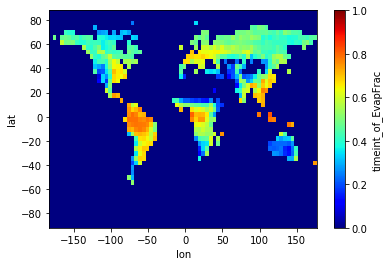

In [16]:
ds=gppbm.timeint_of_gpp
ds_out = xr.Dataset({'lat': (['lat'], np.arange(-90, 90, 4.0)),
                     'lon': (['lon'], np.arange(-180, 180, 5.0)),
                    }
                   )
regridder = xe.Regridder(ds, ds_out, 'bilinear')
regridder.clean_weight_file()
regridder
ds_out_obs = regridder(ds)
ds_out_obs = ds_out_obs.where(ds_out_obs<10000,0,0)

ds=etbm.timeint_of_et
regridder = xe.Regridder(ds, ds_out, 'bilinear')
regridder.clean_weight_file()
regridder
ds_out_ET_obs = regridder(ds)
ds_out_ET_obs = ds_out_obs.where(ds_out_ET_obs<10000,0,0)
#ds_out_ET_obs.plot()

ds=efbm.timeint_of_EvapFrac
regridder = xe.Regridder(ds, ds_out, 'bilinear')
regridder.clean_weight_file()
regridder
ds_out_EF_obs = regridder(ds)
ds_out_EF_obs = ds_out_EF_obs.where(ds_out_EF_obs<10000,0,0)
ds_out_EF_obs.plot(vmax=1,cmap='jet')



<h4>Default ensemble member</h4>

In [17]:

run=caseroot+str(0)
arc = output + 'archive/' + run + '/lnd/hist/'
# arc = output + run + '/run/'   
f2=(arc +run+yr+str(ychoose)+'-01.nc') 
print(f2)
if(os.path.isfile(f2)):
    dsdef = xr.open_mfdataset(arc +run+yr+str(ychoose)+'*', decode_times=False)
else:
    arc = output + run + '/run/'
    dsdef = xr.open_mfdataset(arc +run+yr+str(ychoose)+'*', decode_times=False)
print(arc)

/glade/scratch/rfisher/archive/nocomp_fates_02_n0/lnd/hist/nocomp_fates_02_n0.clm2.h0.2009-01.nc
/glade/scratch/rfisher/archive/nocomp_fates_02_n0/lnd/hist/


<h3>Make output figure directory</h3>

In [18]:
%%bash -s "$notebookdr"  
notebookdr=$2

cd $notebookdr
if [[ -d "figs" ]]
then
   echo "existing fig firectory"
else 
    mkdir figs
    echo "made fig firectory"
fi

existing fig firectory


<h3>Concatenate a year of values in each history directory</h3>

In [26]:
# Concatenature years in question using python. 
if doanalysis ==1:
    vs=range(0,15) 
    print(vs)
    count=1
    ncol=3
    print(caseroot)
    for i in vs:
        print(i)
        run=caseroot+str(i)
        arc = output + 'archive/' + run + '/lnd/hist/'
        f2= arc + '/'+str(ychoose)+'combined.nc'
        if(os.path.isdir(arc)):
            arc = arc
        else:
            arc = output + run + '/run/'
        fileout = arc + '/'+str(ychoose)+'combined.nc'
        #os.remove(fileout)
        print(fileout)
        if(os.path.isfile(fileout)):
            print('file exists')
            arc=arc
        else:
            ds0 = xr.open_mfdataset(arc +run+yr+str(ychoose)+'*', decode_times=False)
            ds0.to_netcdf(fileout)
            print(arc)
print(arc)
print('end')
                      

range(0, 15)
nocomp_fates_02_n
0
/glade/scratch/rfisher/archive/nocomp_fates_02_n0/lnd/hist//2018combined.nc


OSError: no files to open

<h3>Make a single data structure for the ensemble</h3>

In [20]:
# Concatenature years in question using python. 
if doanalysis ==1:
    vs=range(0,15) 
    #count=1
    run=caseroot+str(1)
    arc = output + 'archive/' + run + '/lnd/hist/'
    arc = output + run + '/run/'
    files = sorted(os.listdir(arc))
   
    ncol=3
    for i in vs:
        run=caseroot+str(i)
        arc = output + 'archive/' + run + '/lnd/hist/'
        f2=(arc +run+yr+str(ychoose)+'-01.nc') 
        if(os.path.isfile(f2)):
            arc=arc
        else:
            arc = output + run + '/run/'
        print(arc)
        fileout = arc + '2009combined.nc'
        files[i]=fileout
files=files[slice(0,15)]
dse1=xr.open_mfdataset(files, concat_dim='realization',decode_times=False)

/glade/scratch/rfisher/archive/nocomp_fates_02_n0/lnd/hist/
/glade/scratch/rfisher/archive/nocomp_fates_02_n1/lnd/hist/
/glade/scratch/rfisher/archive/nocomp_fates_02_n2/lnd/hist/
/glade/scratch/rfisher/archive/nocomp_fates_02_n3/lnd/hist/
/glade/scratch/rfisher/archive/nocomp_fates_02_n4/lnd/hist/
/glade/scratch/rfisher/archive/nocomp_fates_02_n5/lnd/hist/
/glade/scratch/rfisher/archive/nocomp_fates_02_n6/lnd/hist/
/glade/scratch/rfisher/archive/nocomp_fates_02_n7/lnd/hist/
/glade/scratch/rfisher/archive/nocomp_fates_02_n8/lnd/hist/
/glade/scratch/rfisher/archive/nocomp_fates_02_n9/lnd/hist/
/glade/scratch/rfisher/archive/nocomp_fates_02_n10/lnd/hist/
/glade/scratch/rfisher/archive/nocomp_fates_02_n11/lnd/hist/
/glade/scratch/rfisher/archive/nocomp_fates_02_n12/lnd/hist/
/glade/scratch/rfisher/archive/nocomp_fates_02_n13/lnd/hist/
/glade/scratch/rfisher/archive/nocomp_fates_02_n14/lnd/hist/


<h3> ET plot</h3>

figs/ensemble_ET_delta_abs_nocomp_fates_02_n14.png


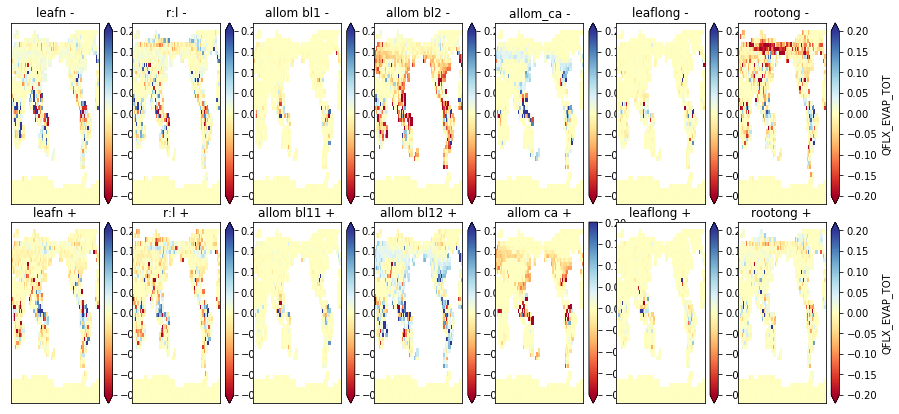

In [27]:
import time
delta=1
rel=0

if doanalysis ==1:
    ds_out = xr.Dataset({'lat': (['lat'], np.arange(-90, 90, 4.0)),
                     'lon': (['lon'], np.arange(-180, 180, 5)),})
    conv=24*3600
    fig = plt.figure()
    plt.rcParams['figure.figsize'] = [15,7]
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    vs=[1, 2, 5,6, 7, 8]
    
    vs=range(1,15)
    count=1
    ncol=7
    for i in vs:
        index=((count+1) % 2)*ncol + ((count+1) // 2)
        ax = fig.add_subplot(2, ncol, index)
        count=count+1
        ds0=dse1.isel(realization=i)
        if(delta == 1):
            mod=np.multiply(np.mean(ds0.QFLX_EVAP_TOT,0),conv)
            deft=np.multiply(np.mean(dsdef.QFLX_EVAP_TOT,0),conv)
            if(rel==0):
                delt=mod-deft
                plt1=delt.plot(vmin=-0.2, vmax=0.2,cmap='RdYlBu')
            else: #relativised diffs 
                delt=(100*(mod-deft)/deft)
                plt1=delt.plot(vmin=-1, vmax=1,cmap='RdYlBu') 
        else:
             ds=np.multiply(np.mean(ds0.QFLX_EVAP_TOT,0),conv)
             regridder = xe.Regridder(ds, ds_out, 'bilinear')
             regridder.clean_weight_file()
             regridder
             ds_out_model = regridder(ds)
             if(rel==1):
                diff=100*(ds_out_model-ds_out_ET_obs)/ds_out_ET_obs
                plt1=diff.plot(vmin=-100, vmax=0,cmap='RdYlBu') 
             else:
                diff=(ds_out_model-ds_out_ET_obs)
                plt1=diff.plot(vmin=-6, vmax=6,cmap='RdYlBu') 
        ax.set_title(titles[i-1]) 
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        fig.canvas.draw()
        time.sleep(1) 
        
if(delta == 1):
    if(rel==1):
        fnmfig='figs/ensemble_ET_delta_rel_'+caseroot +str(i)+'.png'
    else:
        fnmfig='figs/ensemble_ET_delta_abs_'+caseroot +str(i)+'.png'       
else:
    if(rel==1):
        fnmfig='figs/ensemble_ET_error_rel_'+caseroot +str(i)+'.png'
    else:
        fnmfig='figs/ensemble_ET_error_abs_'+caseroot +str(i)+'.png'       

print(fnmfig)
plt.savefig(fnmfig)

<h3> GPP plot</h3>

range(1, 15)
figs/ensemble_GPP_delta_abs_nocomp_fates_02_n14.png


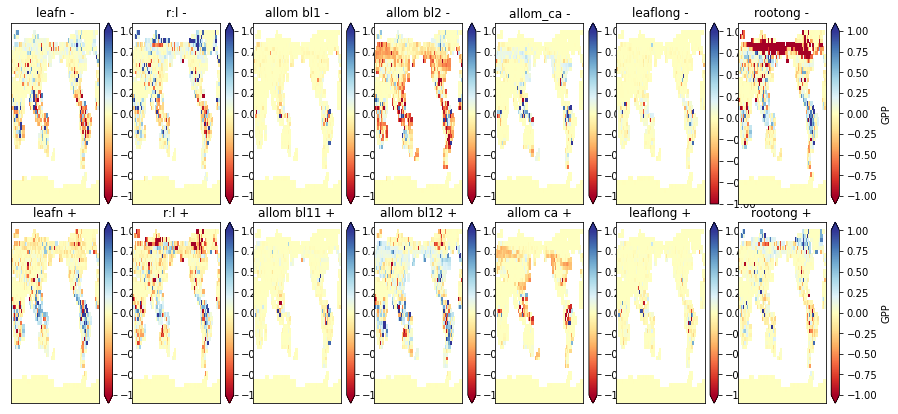

In [22]:
import time
delta=1
rel=0
if doanalysis ==1:
    conv=24*3600
    fig = plt.figure()
    plt.rcParams['figure.figsize'] = [15,7]
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    vs=[1, 2, 5,6, 7, 8]
    
    vs=range(1,15)
    print(vs)
    count=1
    ncol=7
    for i in vs:
        index=((count+1) % 2)*ncol + ((count+1) // 2)
        ax = fig.add_subplot(2, ncol, index)
        count=count+1
        ds0=dse1.isel(realization=i)
        if(delta == 1):
            mod=np.multiply(np.mean(ds0.GPP,0),conv)
            deft=np.multiply(np.mean(dsdef.GPP,0),conv)
            if(rel==0):
                delt=mod-deft
                plt1=delt.plot(vmin=-0.5, vmax=0.5,cmap='RdYlBu')
            else: #relativised diffs 
                delt=100*(mod-deft)/deft
                plt1=delt.plot(vmin=-1, vmax=1,cmap='RdYlBu') 
        else:
             ds=np.multiply(np.mean(ds0.GPP,0),conv)
             ds_out = xr.Dataset({'lat': (['lat'], np.arange(-90, 90, 4.0)),
                     'lon': (['lon'], np.arange(-180, 180, 5)),})
             regridder = xe.Regridder(ds, ds_out_model, 'bilinear')
             regridder.clean_weight_file()
             regridder
             ds_out_model = regridder(ds)
             diff=ds_out_model-ds_out_GPP_obs
             plt1=diff.plot(vmin=-6, vmax=6,cmap='RdYlBu') 
        

        #plt1=ds_out_model.plot(vmin=0, vmax=12,cmap='bwr') 
        ax.set_title(titles[i-1]) 
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        fig.canvas.draw()
        time.sleep(1) 
        
if(delta == 1):
    if(rel==1):
        fnmfig='figs/ensemble_GPP_delta_rel_'+caseroot +str(i)+'.png'
    else:
        fnmfig='figs/ensemble_GPP_delta_abs_'+caseroot +str(i)+'.png'       
else:
    if(rel==1):
        fnmfig='figs/ensemble_GPP_error_rel_'+caseroot +str(i)+'.png'
    else:
        fnmfig='figs/ensemble_GPP_error_abs_'+caseroot +str(i)+'.png'       

print(fnmfig)
plt.savefig(fnmfig)

<h3> LAI Plot<.h3>

range(1, 15)
del abs
del abs
del abs
del abs
del abs
del abs
del abs
del abs
del abs
del abs
del abs
del abs
del abs
del abs
figs/ensemble_TLAI_delta_abs_nocomp_fates_02_n14.png


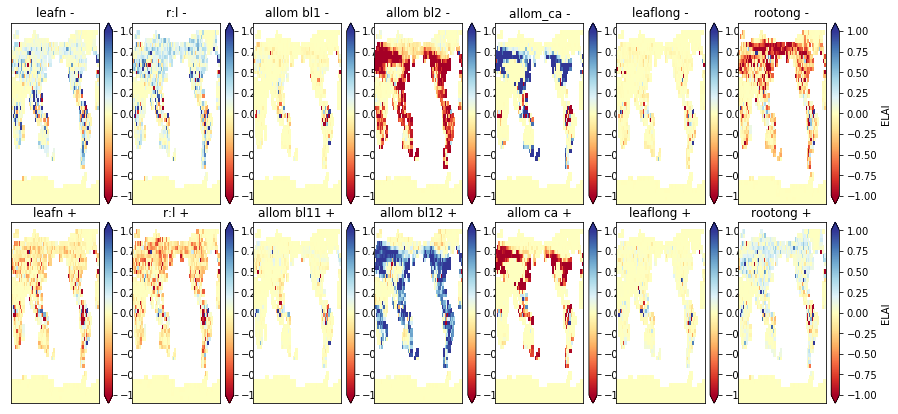

In [23]:
import time
delta=1
rel=0
if doanalysis ==1:
    conv=1
    fig = plt.figure()
    plt.rcParams['figure.figsize'] = [15,7]
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    vs=[1, 2, 5,6, 7, 8]
    
    vs=range(1,15)
    print(vs)
    count=1
    ncol=7
    for i in vs:
        index=((count+1) % 2)*ncol + ((count+1) // 2)
        ax = fig.add_subplot(2, ncol, index)
        count=count+1
        ds0=dse1.isel(realization=i)
        if(delta == 1):
            mod=np.multiply(np.mean(ds0.ELAI,0),conv)
            deft=np.multiply(np.mean(dsdef.ELAI,0),conv)
            print('del abs')
            if(rel==0):
                delt=mod-deft
                plt1=delt.plot(vmin=-1, vmax=1,cmap='RdYlBu')
            else: #relativised diffs 
                delt=100*(mod-deft)/deft
                plt1=delt.plot(vmin=-5, vmax=5,cmap='RdYlBu') 
        else:
             ds=np.multiply(np.mean(ds0.ELAI,0),conv)
             ds_out = xr.Dataset({'lat': (['lat'], np.arange(-90, 90, 4.0)),
                     'lon': (['lon'], np.arange(-180, 180, 5)),})
             regridder = xe.Regridder(ds, ds_out_model, 'bilinear')
             regridder.clean_weight_file()
             regridder
             ds_out_model = regridder(ds)
             diff=ds_out_model-ds_out_GPP_obs
             plt1=diff.plot(vmin=-6, vmax=6,cmap='RdYlBu') 
        

        #plt1=ds_out_model.plot(vmin=0, vmax=12,cmap='bwr') 
        ax.set_title(titles[i-1]) 
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        fig.canvas.draw()
        time.sleep(1) 
        
if(delta == 1):
    if(rel==1):
        fnmfig='figs/ensemble_TLAI_delta_rel_'+caseroot +str(i)+'.png'
    else:
        fnmfig='figs/ensemble_TLAI_delta_abs_'+caseroot +str(i)+'.png'       
else:
    if(rel==1):
        fnmfig='figs/ensemble_TLAI_error_rel_'+caseroot +str(i)+'.png'
    else:
        fnmfig='figs/ensemble_TLAI_error_abs_'+caseroot +str(i)+'.png'       

print(fnmfig)
plt.savefig(fnmfig)

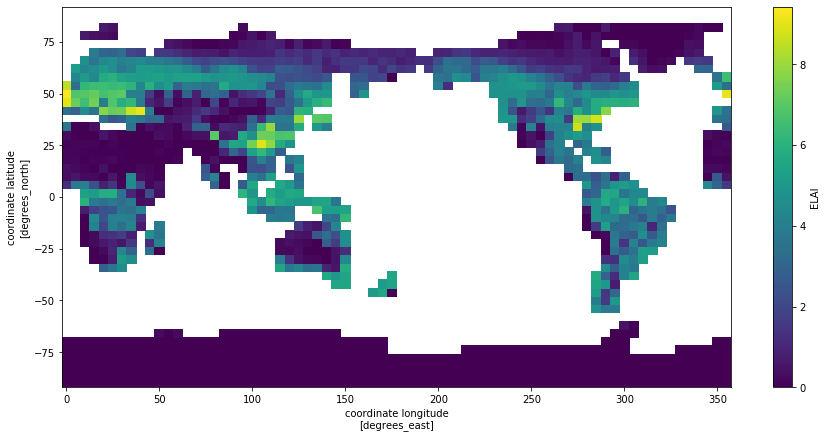

In [24]:
np.mean(ds0.ELAI,0).plot()